In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
class Vocabulary(object):
    
    def __init__(self,token_to_idx=None):
        if token_to_idx is None:
            token_to_idx={}
        self.token_to_idx=token_to_idx
        self.idx_to_token={v:k for k,v in self.token_to_idx.items()}
    
    def to_serializable(self):
        
        return {'token_to_idx':self.token_to_idx}
    @classmethod
    def from_serializable(cls,contents):
        return cls(**contents)
    
    def add_token(self,token):
        
        if token in self.token_to_idx:
            index=self.token_to_idx[token]
        else:
            index=len(self.token_to_idx)
            self.token_to_idx[token]=index
            self.idx_to_token[index]=token
        
        return index
    
    def add_many(self,tokens):
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self,token):
        return self.token_to_idx[token]
    
    def lookup_idx(self,idx):
        if idx not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[idx]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    
    def __init__(self,token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):
        
        super(SequenceVocabulary,self).__init__(token_to_idx)
        
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token
        
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
    
    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents
    
    def lookup_token(self, token):
        
        if self.unk_index>=0:
            return self.token_to_idx.get(token,self.unk_index)
        else:
            return self.token_to_idx[token]

In [4]:
class SurnamesVectorizer(object):
    
    def __init__(self,char_vocab,nationality_vocab):
        self.char_vocab=char_vocab
        self.nationality_vocab=nationality_vocab
    
    
    def vectorize(self,surname,vector_length=-1):
        """
        from_vector  包括所有token 的idx 和 begin_seq_idx ，不包括end_seq_index（假设为1）
        to_vector    包括所有token的idx 和end_seq_index 不包括 begin_seq_dix（假设为0）
        那么对其之后下面的token即为上面要预测（生成）的token
            0  2 3 4 5
            2  3 4 5 1
        """
        #获取该单词的每个字符对应的序号
        indices = [self.char_vocab.begin_seq_index] 
        indices.extend(self.char_vocab.lookup_token(token) for token in surname)
        indices.append(self.char_vocab.end_seq_index)
        
        #如果未初始化
        if vector_length < 0:
            vector_length = len(indices) - 1
            
        #from vector
        from_vector = np.empty(vector_length, dtype=np.int64)
        from_indices=indices[:-1]
        from_vector[:len(from_indices)]=from_indices
        from_vector[len(from_indices):]=self.char_vocab.mask_index
        
        #to_vector
        to_vector=np.empty(vector_length,dtype=np.int64)
        to_indices=indices[1:]
        to_vector[:len(to_indices)]=to_indices
        to_vector[len(to_indices):]=self.char_vocab.mask_index
        
        return from_vector,to_vector
    
    @classmethod
    def from_dataframe(cls,surname_df):
        
        char_vocab=SequenceVocabulary()
        nationality_vocab=Vocabulary()
        
        for index,row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)
        
        return cls(char_vocab,nationality_vocab)


In [5]:
class SurnameDataset(Dataset):
    
    """
    创建数据集格式
    """
    def __init__(self,surname_df,vectorizer):
        
        super(SurnameDataset,self).__init__()
        self.surname_df=surname_df
        self.vectorizer=vectorizer
        
        self._max_seq_length=max(map(len,self.surname_df.surname))+2
        
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}
        
        self.set_split('train')
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """
        从 csv文件中加
        """
        surname_df = pd.read_csv(surname_csv)
        return cls(surname_df, SurnamesVectorizer.from_dataframe(surname_df))
    
    def get_vectorizer(self):
        return self.vectorizer
    
    def set_split(self,split='train'):
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dict[split]
    
    def __len__(self):
        return self._target_size
    
    def __getitem__(self,index):
        
        row=self._target_df.iloc[index]
        from_vector,to_vector=self.vectorizer.vectorize(row.surname,self._max_seq_length)
        nationality_index=self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {
            'x_data':from_vector,
            'y_target':to_vector,
            'class_index':nationality_index
        }
    def get_num_batches(self,batch_size):
        return len(self)//batch_size


def generate_batches(dataset,batch_size,shuffle=True,drop_last=True,device='cpu'):
    """
    数据集，batch_size,是否随机打乱数据，是否丢弃最后一个batch?,设备
    """
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [6]:
class SurnameGenerationModel(nn.Module):
    
    def __init__(self,char_embedding_dim,char_vocab_size,rnn_hidden_dim,batch_first=True,padding_idx=0,dropout_p=0.5):
        
        super(SurnameGenerationModel,self).__init__()
        
        self.char_emb=nn.Embedding(num_embeddings=char_vocab_size,
                                  embedding_dim=char_embedding_dim,
                                  padding_idx=padding_idx)
        
        self.rnn=nn.GRU(input_size=char_embedding_dim,hidden_size=rnn_hidden_dim,batch_first=batch_first)
        
        self.fc=nn.Linear(rnn_hidden_dim,char_vocab_size)
        
        self._dropout_p=dropout_p
    
    def forward(self,x_in,apply_softmax=False):
        
        x_embedded=self.char_emb(x_in)
        y_out,_=self.rnn(x_embedded)
        
        batch_size,seq_size,feat_size=y_out.shape
        
        #变成二维的
        y_out=y_out.contiguous().view(batch_size*seq_size,feat_size)
        
        y_out=self.fc(F.dropout(y_out,p=self._dropout_p))
        
        if apply_softmax:
            y_out=F.softmax(y_out,dim=1)
        
        new_feat_size=y_out.shape[-1]
        y_out=y_out.view(batch_size,seq_size,new_feat_size)
        #y_out 的shape 为batch_size  max_word_length   char_vocab_size
        return y_out

In [7]:
class SurnameGenerationModel_conditioned(nn.Module):
    
    def __init__(self,char_embedding_dim,char_vocab_size,num_nationalities,rnn_hidden_dim,batch_first=True,padding_idx=0,dropout_p=0.5):
        
        super(SurnameGenerationModel_conditioned,self).__init__()
        
        self.char_emb=nn.Embedding(num_embeddings=char_vocab_size,
                                  embedding_dim=char_embedding_dim,
                                  padding_idx=padding_idx)
        self.national_emb=nn.Embedding(num_embeddings=num_nationalities,
                                            embedding_dim=rnn_hidden_dim)
        self.rnn=nn.GRU(input_size=char_embedding_dim,hidden_size=rnn_hidden_dim,batch_first=batch_first)
        
        self.fc=nn.Linear(rnn_hidden_dim,char_vocab_size)
        
        self._dropout_p=dropout_p
    
    def forward(self,x_in,nationality_index,apply_softmax=False):
        
        x_embedded=self.char_emb(x_in)
        nationality_embeded=self.national_emb(nationality_index).unsqueeze(0)
        y_out,_=self.rnn(x_embedded,nationality_embeded)
        
        batch_size,seq_size,feat_size=y_out.shape
        
        #变成二维的
        y_out=y_out.contiguous().view(batch_size*seq_size,feat_size)
        
        y_out=self.fc(F.dropout(y_out,p=self._dropout_p))
        
        if apply_softmax:
            y_out=F.softmax(y_out,dim=1)
        
        new_feat_size=y_out.shape[-1]
        y_out=y_out.view(batch_size,seq_size,new_feat_size)
        #y_out 的shape 为batch_size  max_word_length   char_vocab_size
        return y_out

In [8]:
def sample_from_model(model,vectorizer,num_samples=1,sample_size=20,temperature=1.0):
    """
    使用训练好的模型
    indices (torch.Tensor): the matrix of indices; 
        shape = (num_samples, sample_size)
    """
    #获取和样本数目一样的begin_seq_index
    begin_seq_index=[vectorizer.char_vocab.begin_seq_index for _ in range(num_samples)]
    #转化为二维
    begin_seq_index = torch.tensor(begin_seq_index, dtype=torch.int64).unsqueeze(dim=1)
    #转化为3维
    indices=[begin_seq_index]
    
    h_t=None
    for time_step in range(sample_size):
        #获取某个样本的
        x_t=indices[time_step]
        x_emb_t=model.char_emb(x_t)
        rnn_out_t,h_t=model.rnn(x_emb_t,h_t)
        #因为是char 所以数据的格式维度为 batch_size 1 feats_size
        prediction_vector=model.fc(rnn_out_t.squeeze(dim=1))
        
        #使用softmax
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        #取值，获取
        indices.append(torch.multinomial(probability_vector, num_samples=1))
        
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

def decode_samples(sampled_indices,vectorizer):
    """将indices 转化为surname
    """
    decoded_surnames=[]
    vocab=vectorizer.char_vocab
    
    for sample_index in range(sampled_indices.shape[0]):
        surname=''
        for time_step in range(sampled_indices.shape[1]):
            #获取每个时间步的index
            sample_item=sampled_indices[sample_index,time_step].item()
            #为开头就跳过
            if sample_item == vocab.begin_seq_index:
                continue
            #为结尾就跳出
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname+=vocab.lookup_idx(sample_item)
        decoded_surnames.append(surname)
    return decoded_surnames

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}
def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred,y_true):
    #y_pred 是模型的输出，如果是三维的那就转化为矩阵
    #y_true是真实的值，为矩阵就转化为一维向量
    if len(y_pred.size())==3:
        y_pred=y_pred.contiguous().view(-1,y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    _,y_pred_indices=y_pred.max(dim=1)
    #根据真实的字符得出与模型输出的字符相比较     1 0 1 0 1 
    correct_indices=torch.eq(y_pred_indices,y_true).float()
    #两个tensor得出不相等的每项，相等为0，不想等为1      即真实值与mask  假设y_true 为 2 4 6 0 （0为mask_index）
    #                                                                                  0 0 0 0
    #则valil_indices 为                                                                1 1 1 0
    valid_indices = torch.ne(y_true, mask_index).float()
    #除去mask 后预测成功的值
    n_correct = (correct_indices * valid_indices).sum().item()
    #真实字符个数
    n_valid = valid_indices.sum().item()
    #准确率
    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    """
    计算loss
    """
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

def plot_performance(train_state,args):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(train_state["train_loss"], label="train")
        plt.plot(train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(train_state["train_acc"], label="train")
        plt.plot(train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(args.save_dir, "performance.png"))

        # Show plots
        plt.show()

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [11]:
args = Namespace(
    #训练数据
    surname_csv="../data/surnames/surnames_with_splits.csv",
    model_state_file="model.pth",
    save_dir="model_storage/model1_unconditioned_surname_generation",
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size=32,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [12]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

Expanded filepaths: 
	model_storage/model1_unconditioned_surname_generation\model.pth


In [13]:
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True


In [14]:
#加载数据集
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
#获取向量化对象类
vectorizer=dataset.get_vectorizer()

model=SurnameGenerationModel_conditioned(char_embedding_dim=args.char_embedding_size,
                            char_vocab_size=len(vectorizer.char_vocab),
                            num_nationalities=len(vectorizer.nationality_vocab),
                            rnn_hidden_dim=args.rnn_hidden_size,
                            padding_idx=vectorizer.char_vocab.mask_index)

In [15]:
mask_index=vectorizer.char_vocab.mask_index

model=model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

In [16]:
try:
    
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index']=epoch_index
        
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        
        
        
        for batch_index, batch_dict in enumerate(batch_generator):
            
            #梯度归零
            optimizer.zero_grad()
            
            #得到模型输出
            y_pred = model(x_in=batch_dict['x_data'],nationality_index=batch_dict['class_index'])
            
            #计算loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            
            #梯度下降
            loss.backward()
            
            #参数更新
            optimizer.step()
            
            #计算loss 和准确度
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            #更新进度条
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        
        
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()
        
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'],nationality_index=batch_dict['class_index'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])
        
        
        if train_state['stop_early']:
            break
        
        model=model.cpu()
        sampled_surname=decode_samples(sample_from_model(model,vectorizer,num_samples=2),vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surname[0], sample2=sampled_surname[1])
        
        
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")        

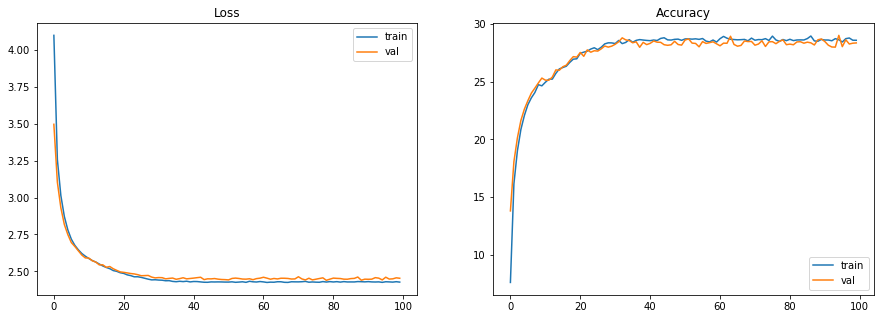

In [17]:
plot_performance(train_state,args)

In [18]:
#加载效果最好的模型
model.load_state_dict(torch.load(train_state['model_filename']))
#转化为
model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'],nationality_index=batch_dict['class_index'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc

In [19]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.4618309934933986;
Test Accuracy: 28.208222237232878


In [20]:
#测试，随机生成10各样本
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Eip
Raras
Jigi
Chabro
Pouek
Árosanibs
Hallas
Charhka
Ravuy
Tuarca
